In [163]:
# Kaggle案例：泰坦尼克号

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# 导入数据集

train = pd.read_csv('./datasets/titanic/train.csv')
test = pd.read_csv('./datasets/titanic/test.csv')

# PassengerId 乘客ID
# Survived 是否幸存。0遇难，1幸存
# Pclass 船舱等级，1Upper，2Middle，3Lower
# Name 姓名
# Sex 性别
# Age 年龄
# SibSp 兄弟姐妹及配偶个数
# Parch 父母或子女个数
# Ticket 乘客的船票号
# Fare 乘客的船票价
# Cabin 乘客所在舱位
# Embarked 乘客登船口岸

train.head()                                          # 查看数据集前几行数据

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
print(train.shape)                                   # 查看数据行数、列数

(891, 12)


In [44]:
print(train.info())                                  # 查看数据集的基本情况，查看缺失的数据情况，并进行数据处理 
print('\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-nul

In [14]:
# 剔除无关和缺失较多的数据，分别剔除：名字、船票ticket、船舱、登船口岸
# .loc 通过自定义索引获取数据 , 其中 .loc[:,:]中括号里面逗号前面的表示行，逗号后面的表示列

refresh_train = train.loc[:, ['PassengerId','Survived','Pclass','Sex','Age','SibSp','Parch','Fare']]
refresh_test = test.loc[:, ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare']]

In [38]:
# 填充年龄空值（填充年龄的中位数代替空值）

train_age = refresh_train['Age'].median()                                          # 获取乘客年龄的中位数
test_age = refresh_train['Age'].median()

print(refresh_train['Age'].isnull().head())                                        # 查看年龄是否为空，返回True/False

refresh_train.loc[refresh_train['Age'].isnull(), 'Age'] = train_age                # 将年龄为空值的地方填充为年龄中位数
refresh_test.loc[refresh_test['Age'].isnull(), 'Age'] = test_age

0    False
1    False
2    False
3    False
4    False
Name: Age, dtype: bool


In [61]:
# 填充船票价格（填充船票的众数代替空值）
                    
test_fare = refresh_test['Fare'].mode()                                            # 测试集中有一条数据为空，获取测试集中船票的众数

print(refresh_test.loc[refresh_test['Fare'].isnull(), 'Fare'])                     # 打印查看是否有数据集船票为空
refresh_test.loc[refresh_test['Fare'].isnull(), 'Fare'] = test_fare[0]
# print(refresh_test.loc[refresh_test['Fare'].isnull(), 'Fare'])

Series([], Name: Fare, dtype: float64)


In [185]:
# 将性别从字符串类型转化为整数类型

# refresh_train['Sex'] = refresh_train['Sex'].map({"male":1, "female":0}).astype(int)          # 将该列的值为male映射为1，female映射为0
refresh_test['Sex'] = refresh_test['Sex'].map({"male":1, "female":0}).astype(int)  
print(refresh_train.head())

   PassengerId  Survived  Pclass  Sex   Age     Fare  familysize  isalone
0            1         0       3    1  22.0   7.2500           2        1
1            2         1       1    0  38.0  71.2833           2        1
2            3         1       3    0  26.0   7.9250           1        1
3            4         1       1    0  35.0  53.1000           2        1
4            5         0       3    1  35.0   8.0500           1        1


In [80]:
# 数据重构，增加两个特征：家庭总人口、是否单身

refresh_train['familysize'] = refresh_train.loc[:, 'SibSp']+refresh_train.loc[:, 'Parch']+1    # 兄妹个数+父母子女数+自己本身
refresh_test['familysize'] = refresh_test.loc[:, 'SibSp']+refresh_test.loc[:, 'Parch']+1

refresh_train['isalone'] = refresh_train.loc[refresh_train['familysize']==1, 'isalone'] = 1    # 当计算到家庭总数为1时，表示是单身孤身一人
refresh_test['isalone'] = refresh_test.loc[refresh_test['familysize']==1, 'isalone'] = 1

refresh_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,familysize,isalone
0,1,0,3,1,22.0,1,0,7.2500,2,1
1,2,1,1,0,38.0,1,0,71.2833,2,1
2,3,1,3,0,26.0,0,0,7.9250,1,1
3,4,1,1,0,35.0,1,0,53.1000,2,1
4,5,0,3,1,35.0,0,0,8.0500,1,1


In [84]:
# 获取重构后的数据，去掉兄弟姐妹和父母子女数，增加为家庭总人口和是否单身

refresh_train = refresh_train.loc[:, ['PassengerId','Survived','Pclass','Sex','Age','Fare','familysize','isalone']]
refresh_test = refresh_test.loc[:, ['PassengerId','Pclass','Sex','Age','Fare','familysize','isalone']]

         Survived
isalone          
1        0.383838
0        0.616162


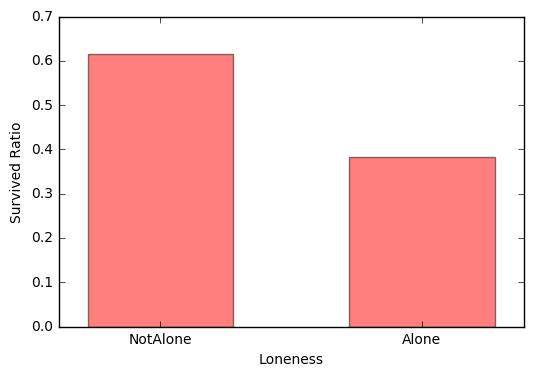

In [142]:
# 数据分析

# 分析单身与存活率的关系
survived_ratio = refresh_train[["isalone", "Survived"]].groupby(['isalone']).mean()             # 按isalone进行分组统计存活的平均数
survived_ratio.loc[0, 'Survived'] = 1-survived_ratio.loc[1, 'Survived']
print(survived_ratio)

plt.bar(
    [0.1, 1],                                                                                     # 每个柱子左移的范围
    [survived_ratio.loc[0,'Survived'],survived_ratio.loc[1,'Survived']],                          # y轴的数字
    0.5,                                                                                          # 柱子的宽度
    color='r',                                                                                    # 柱子的颜色
    alpha=0.5,                                                                                    # 透明度
)

plt.xticks([0.35,1.25], ['NotAlone','Alone'])                                                     # 设置x坐标系的信息，(文字的左距，文字内容）
plt.xlabel("Loneness")
plt.ylabel("Survived Ratio")
plt.show()

     Survived
Sex          
0    0.742038
1    0.188908


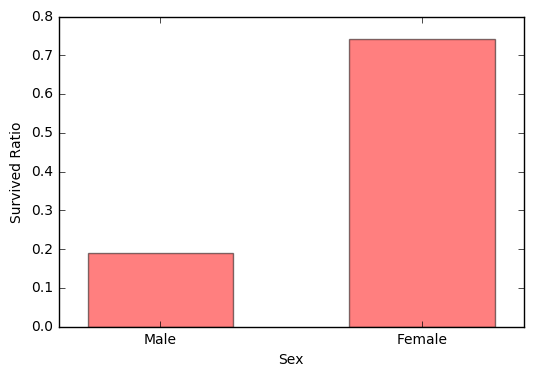

In [143]:
# 分析男女存活率

sex_survivedRatio = refresh_train[['Sex', 'Survived']].groupby(["Sex"]).mean()
print(sex_survivedRatio)

plt.bar(
    [0.1, 1], 
    [sex_survivedRatio.loc[1, 'Survived'], sex_survivedRatio.loc[0, 'Survived']], 
    0.5,
    color='r',                                                                                  
    alpha=0.5,  
)

plt.xticks([0.35, 1.25], ['Male', 'Female'])
plt.xlabel("Sex")
plt.ylabel("Survived Ratio")
plt.show()

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


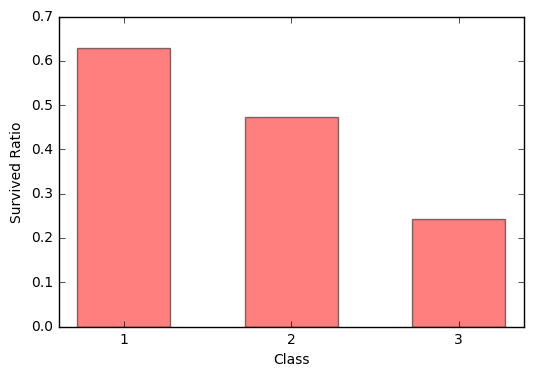

In [152]:
# 分析仓位存活率

p_survivedRatio = refresh_train[['Pclass', "Survived"]].groupby(['Pclass']).mean()
print(p_survivedRatio)

plt.bar(
    [0.1, 1, 1.9], 
    [p_survivedRatio.loc[1, 'Survived'], p_survivedRatio.loc[2, 'Survived'],  p_survivedRatio.loc[3, 'Survived']], 
    0.5,
    color='r',                                                                                  
    alpha=0.5,  
)

plt.xticks([0.35, 1.25, 2.15], ['1', '2', '3'])
plt.xlabel("Class")
plt.ylabel("Survived Ratio")
plt.show()

      Survived
Age           
0.42       1.0
0.67       1.0
0.75       1.0
0.83       1.0
0.92       1.0


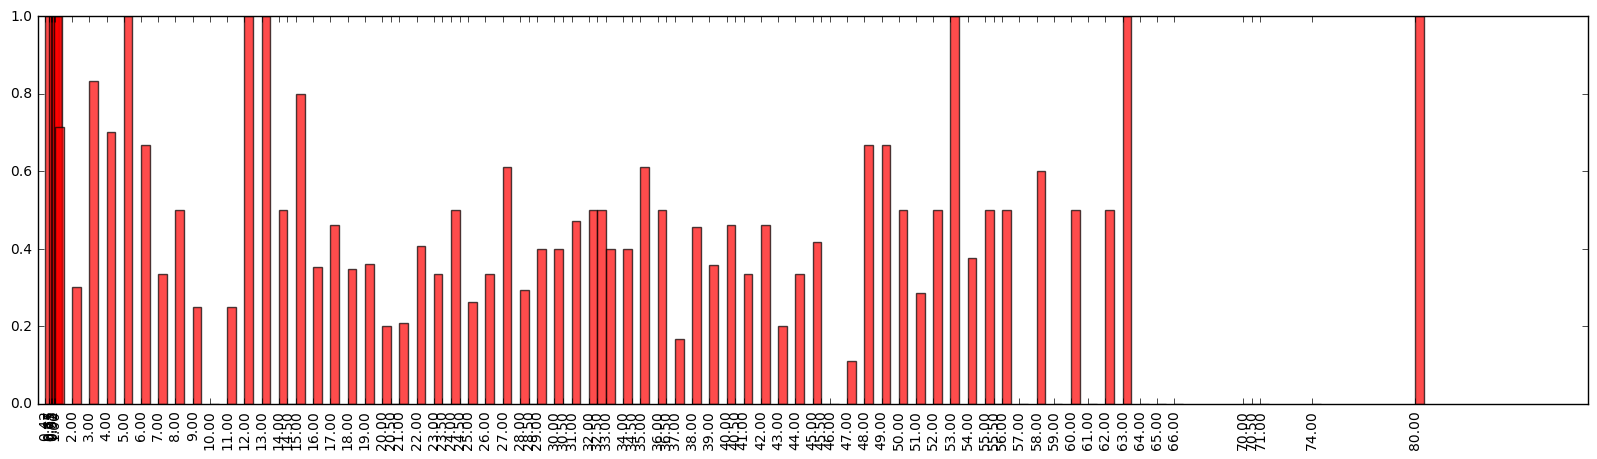

In [162]:
# 分析年龄存活率

age_survivedRatio = refresh_train[['Age', "Survived"]].groupby(['Age']).mean()
print(age_survivedRatio.head())

plt.figure(2, figsize=(20,5))                                                         # 定义两个字图，宽高为20,5
plt.bar(
    age_survivedRatio.index,
    age_survivedRatio.values,
    0.5,
    color='r',
    alpha=0.7
)
# plt.axis([0,80,0,20])
plt.xticks(age_survivedRatio.index,rotation=90)                                       # rotation:文本显示时旋转的角度,90度表示垂直显示

plt.show()

        Survived
Fare            
0.0000  0.066667
4.0125  0.000000
5.0000  0.000000
6.2375  0.000000
6.4375  0.000000


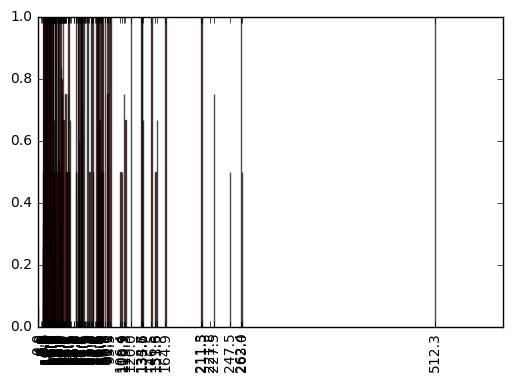

In [161]:
# 分析船票与存活率的关系 

fare_survivedRatio = refresh_train[['Fare', "Survived"]].groupby(['Fare']).mean()
print(fare_survivedRatio.head())

plt.figure(2, figsize=(20,5))
plt.bar(
    fare_survivedRatio.index,
    fare_survivedRatio.values,
    0.5,
    color='r',
    alpha=0.7
)
# plt.axis([0,80,0,20])
plt.xticks(fare_survivedRatio.index,rotation=90)

plt.show()

In [183]:
# 建立机器学习模型，利用KNN算法

x_train = refresh_train.loc[:, ['Pclass','Sex','familysize']]
y_train = np.array(refresh_train.loc[:, ['Survived']]).reshape(x_train.shape[0])

knc = KNeighborsClassifier(n_neighbors = 20)
knc.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [189]:
x_test = refresh_test.loc[:, ['Pclass','Sex','familysize']]

prediction = knc.predict(x_test)
print(prediction)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [229]:
# 保存为指定格式的CSV
# s = np.arange(892, 1310)

s = np.arange(892, 1310)                                          # 索引顺序为规定的
results = pd.DataFrame(columns=["Passengers", "Survived"])
results['Passengers'] = s
results["Survived"] = prediction

print(results.head())
results.to_csv("./result.xlsx", index=False)                      # 不把索引导出

   Passengers  Survived
0         892         0
1         893         0
2         894         0
3         895         0
4         896         1
